# Path to Zenodo files folder

In [1]:
path = 'PATH/TO/ZENODO/FILES/FOLDER'

# Figure S6

## Panel a

In [2]:
import pandas as pd
from os import listdir
from os.path import isfile, join

columns = ['Query','Target','E-value','SeqId','QueryStart', 'QueryEnd','QueryLen', 'TargetStart',
          'TargetEnd','TargetLen', 'Align_len', 'Score', 'QuerySeq', 'TargetSeq', 'mismatch',
           'QueryCov','TargetCov', 'taxid','taxname','taxlineage','lddt','alntmscore','rmsd','prob']

isofolds=pd.read_csv(path+'Fig5/fyn_aln1_AFUniprot',names=columns,sep='\t')

reliable_isofolds = isofolds.loc[isofolds['alntmscore']>0.6].loc[isofolds['prob']==1].loc[isofolds['QueryStart']<3].loc[isofolds['QueryEnd']>53].loc[isofolds['rmsd']<2].drop_duplicates('TargetSeq').copy()

In [3]:
#allDTS core finding

DTS=['F','L','I','M','V']

wt=reliable_isofolds.iloc[0]['QuerySeq']
mut_pos = [2,16,18,24,26,48,53]
wtcore=''.join([reliable_isofolds.iloc[0]['QuerySeq'][i] for i in mut_pos])

aatype_pos=[]
for i in mut_pos:
    aatyperange=0
    for res in wt[:i]:
        if res == wt[i-1]:
            aatyperange+=1
    aatype_pos.append(aatyperange)
    
totalerrors=0
for index, row in reliable_isofolds.iterrows():
    query=row.QuerySeq
    target=row.TargetSeq
    target_mut_pos=[]
    query_hyphens=[]
    iterator=0
    for i in query:
        if i=='-':
            query_hyphens.append(iterator)
        iterator+=1
        
    aligned_target=list(target)
    iterator=0
    for i in query_hyphens:
        del(aligned_target[i+iterator])
        iterator-=1
    aligned_target=''.join(aligned_target)
    mut_pos_test = [x+1 - row.QueryStart for x in mut_pos]
    mut=[]
    for pos in mut_pos_test:
        try:
            mut.append(aligned_target[pos])
        except IndexError:
            totalerrors+=1
        
    if ''.join(mut) == wtcore:
        reliable_isofolds.at[index,'WTcore']=True
        reliable_isofolds.at[index,'Nham']=0
    else:
        reliable_isofolds.at[index,'WTcore']=False
        nham=0
        for mutres, wtres in zip(mut,wtcore):
            if mutres != wtres:
                nham+=1
        reliable_isofolds.at[index,'Nham']=nham
        
    reliable_isofolds.at[index,'MutCore']=('').join(mut)
    allDTS=True
    coreDels=False
    for res in mut:
        if res not in DTS:
            allDTS=False
        if res == '-':
            coreDels=True
    reliable_isofolds.at[index,'allDTS']=allDTS
    reliable_isofolds.at[index,'coreDels']=coreDels  


### First-order model

In [4]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order1/task_1/predictions/predicted_phenotypes_supp.txt',
                                  sep='\t', lineterminator='\n', index_col=0)

/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_8582/2768041347.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order1/task_1/predictions/predicted_phenotypes_supp.txt',


In [5]:
cores = {'P06241' : [2,16,18,24,26,48,53]}

for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)

In [6]:
RT=303*0.001987
predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)

predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)

predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT

In [7]:
from itertools import product

DTS = ['F','L','I','M','V']
a=list(product(DTS,repeat=7))

isofold_exist_clasf = pd.DataFrame(index=[''.join(i) for i in a])

isofold_exist_clasf = isofold_exist_clasf.join(predicted_phenotypes.set_index('core')[['mean_dG']])

isofold_exist_clasf['in_nature_all']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_all']=isofold_exist_clasf['in_nature_all'].astype(int)
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.5].loc[reliable_isofolds['SeqId']>0.25].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf['in_nature_25_50'].astype(int)
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.75].loc[reliable_isofolds['SeqId']>0.50].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf['in_nature_50_75'].astype(int)
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.25].loc[reliable_isofolds['SeqId']>0].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf['in_nature_0_25'].astype(int)
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']>0.75].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf['in_nature_75'].astype(int)
isofold_exist_clasf


,mean_dG,in_nature_all,in_nature_25_50,in_nature_50_75,in_nature_0_25,in_nature_75
FFFFFFF,2.217311,0,0,0,0,0
FFFFFFL,1.844577,0,0,0,0,0
FFFFFFI,2.562146,0,0,0,0,0
FFFFFFM,2.459099,0,0,0,0,0
FFFFFFV,2.163977,0,0,0,0,0
...,...,...,...,...,...,...
VVVVVVF,1.297966,0,0,0,0,0
VVVVVVL,0.925231,1,1,0,0,0
VVVVVVI,1.642801,0,0,0,0,0
VVVVVVM,1.539753,0,0,0,0,0


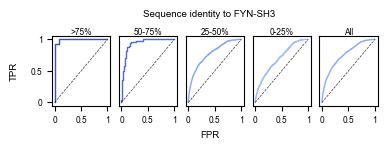

In [8]:
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn import metrics
from sklearn.model_selection import KFold
from IPython.display import display
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

plt.rcParams["font.family"] = "Arial"

titles = {'in_nature_all':'All',
         'in_nature_0_25':'0-25%',
         'in_nature_25_50':'25-50%',
         'in_nature_50_75':'50-75%',
         'in_nature_75':'>75%'}

cmap = plt.get_cmap('coolwarm_r')

classifier_performances = pd.DataFrame()
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(2.8*1.5,0.6*1.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.15)
coliterator=0
for threshold in reversed(['in_nature_all', 'in_nature_0_25','in_nature_25_50', 'in_nature_50_75', 'in_nature_75']):

    # predictors (x): ddG
    # target variable (y): exists in nature?
    x = isofold_exist_clasf[['mean_dG']]
    y = isofold_exist_clasf[[threshold]]

    x, y = shuffle(x, y, random_state=3)
    
    # ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y).ravel(), np.array(-1*x).ravel())
    roc_auc = metrics.auc(fpr, tpr)
    ax[coliterator].plot(fpr, tpr, lw=1, alpha=1, color=cmap(roc_auc),
            label=r'(AUC=%0.2f)' % (roc_auc))
    
    classifier_performances.at[threshold,'AUC']=roc_auc
    
    ax[coliterator].plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k',
             label='', alpha=0.8)
        

    ax[coliterator].set_title(titles[threshold],fontsize=6, pad=0)
    ax[coliterator].set_xticks(np.arange(0,1.2,0.5), [Decimal(i).normalize() for i in np.arange(0,1.2,0.5)],fontsize=6)
    ax[coliterator].set_yticks(np.arange(0,1.2,0.5), [Decimal(i).normalize() for i in np.arange(0,1.2,0.5)],fontsize=6)
    if coliterator > 0:
        ax[coliterator].tick_params(axis='y',length=0)
    coliterator+=1
fig.text(0.5, -0.25, 'FPR', ha='center', fontsize=7)
fig.text(0.025, 0.5, 'TPR', va='center', rotation='vertical', fontsize=7)
fig.text(0.5, 1.1, 'Sequence identity to FYN-SH3', ha='center', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#fig.savefig('FYN_1stordermodel_EBG_classifier_ROC-AUCs_curves_SeqIds.svg', dpi=300, transparent=True, bbox_inches='tight')

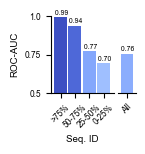

In [9]:
fig, ax = plt.subplot_mosaic([['left','right']],
                            width_ratios = [3.5,1],
                            figsize = (1.1,1))
axis=classifier_performances.iloc[:-1].plot.bar(y='AUC', color=cmap(list(classifier_performances['AUC'])), ax=ax['left'], legend=False, width=0.9, ylim=(0,1.05))
ax['left'].set_xticklabels(reversed(['0-25%', '25-50%', '50-75%', '>75%']), fontsize=6, rotation=45)
ax['left'].set_yticks(np.arange(0,1.2,0.25),[str(round(i,2)) for i in np.arange(0,1.2,0.25)], fontsize=6)
ax['left'].set_ylim(0.5,1)
ax['left'].set_xlabel('Seq. ID', fontsize=7)
ax['left'].set_ylabel('ROC-AUC',fontsize=7)
ax['left'].spines[['top','right']].set_visible(False)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=0)

axis=classifier_performances.iloc[-1:].plot.bar(y='AUC', color=cmap(list(classifier_performances.iloc[-1:]['AUC'])), ax=ax['right'], legend=False, width=0.9, ylim=(0,1.05))
ax['right'].spines[['top','right','left']].set_visible(False)
ax['right'].set_yticks([])
ax['right'].set_ylim(0.5,1)
ax['right'].set_xticklabels(reversed(['All']), fontsize=6, rotation=45)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=0)

plt.subplots_adjust(wspace=0.1)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_1stordermodel_EBG_classifier_ROC-AUCs_SeqIds_2.svg', dpi=300, transparent=True, bbox_inches='tight')

### Second-order model

In [10]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2/task_1/predictions/predicted_phenotypes_supp.txt',
                                  sep='\t', lineterminator='\n', index_col=0)

/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_8582/776368025.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2/task_1/predictions/predicted_phenotypes_supp.txt',


In [11]:
cores = {'P06241' : [2,16,18,24,26,48,53]}

for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)

In [12]:
RT=303*0.001987
predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)

predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)

predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT

In [13]:
from itertools import product

DTS = ['F','L','I','M','V']
a=list(product(DTS,repeat=7))

isofold_exist_clasf = pd.DataFrame(index=[''.join(i) for i in a])

isofold_exist_clasf = isofold_exist_clasf.join(predicted_phenotypes.set_index('core')[['mean_dG']])

isofold_exist_clasf['in_nature_all']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_all']=isofold_exist_clasf['in_nature_all'].astype(int)
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.5].loc[reliable_isofolds['SeqId']>0.25].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf['in_nature_25_50'].astype(int)
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.75].loc[reliable_isofolds['SeqId']>0.50].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf['in_nature_50_75'].astype(int)
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.25].loc[reliable_isofolds['SeqId']>0].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf['in_nature_0_25'].astype(int)
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']>0.75].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf['in_nature_75'].astype(int)
isofold_exist_clasf


,mean_dG,in_nature_all,in_nature_25_50,in_nature_50_75,in_nature_0_25,in_nature_75
FFFFFFF,1.292577,0,0,0,0,0
FFFFFFL,2.495111,0,0,0,0,0
FFFFFFI,3.994768,0,0,0,0,0
FFFFFFM,2.653628,0,0,0,0,0
FFFFFFV,2.595477,0,0,0,0,0
...,...,...,...,...,...,...
VVVVVVF,1.350789,0,0,0,0,0
VVVVVVL,1.319200,1,1,0,0,0
VVVVVVI,2.549130,0,0,0,0,0
VVVVVVM,2.258878,0,0,0,0,0


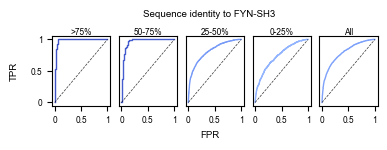

In [14]:
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn import metrics
from sklearn.model_selection import KFold
from IPython.display import display
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

plt.rcParams["font.family"] = "Arial"

titles = {'in_nature_all':'All',
         'in_nature_0_25':'0-25%',
         'in_nature_25_50':'25-50%',
         'in_nature_50_75':'50-75%',
         'in_nature_75':'>75%'}

cmap = plt.get_cmap('coolwarm_r')

classifier_performances = pd.DataFrame()
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(2.8*1.5,0.6*1.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.15)
coliterator=0
for threshold in reversed(['in_nature_all', 'in_nature_0_25','in_nature_25_50', 'in_nature_50_75', 'in_nature_75']):

    # predictors (x): ddG
    # target variable (y): exists in nature?
    x = isofold_exist_clasf[['mean_dG']]
    y = isofold_exist_clasf[[threshold]]

    x, y = shuffle(x, y, random_state=3)
    
    # ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y).ravel(), np.array(-1*x).ravel())
    roc_auc = metrics.auc(fpr, tpr)
    ax[coliterator].plot(fpr, tpr, lw=1, alpha=1, color=cmap(roc_auc),
            label=r'(AUC=%0.2f)' % (roc_auc))
    
    classifier_performances.at[threshold,'AUC']=roc_auc
    
    ax[coliterator].plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k',
             label='', alpha=0.8)
        

    ax[coliterator].set_title(titles[threshold],fontsize=6, pad=0)
    ax[coliterator].set_xticks(np.arange(0,1.2,0.5), [Decimal(i).normalize() for i in np.arange(0,1.2,0.5)],fontsize=6)
    ax[coliterator].set_yticks(np.arange(0,1.2,0.5), [Decimal(i).normalize() for i in np.arange(0,1.2,0.5)],fontsize=6)
    if coliterator > 0:
        ax[coliterator].tick_params(axis='y',length=0)
    coliterator+=1
fig.text(0.5, -0.25, 'FPR', ha='center', fontsize=7)
fig.text(0.025, 0.5, 'TPR', va='center', rotation='vertical', fontsize=7)
fig.text(0.5, 1.1, 'Sequence identity to FYN-SH3', ha='center', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#fig.savefig('FYN_2ndordermodel_EBG_classifier_ROC-AUCs_curves_SeqIds.svg', dpi=300, transparent=True, bbox_inches='tight')

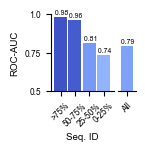

In [15]:
fig, ax = plt.subplot_mosaic([['left','right']],
                            width_ratios = [3.5,1],
                            figsize = (1.1,1))
axis=classifier_performances.iloc[:-1].plot.bar(y='AUC', color=cmap(list(classifier_performances['AUC'])), ax=ax['left'], legend=False, width=0.9, ylim=(0,1.05))
ax['left'].set_xticklabels(reversed(['0-25%', '25-50%', '50-75%', '>75%']), fontsize=6, rotation=45)
ax['left'].set_yticks(np.arange(0,1.2,0.25),[str(round(i,2)) for i in np.arange(0,1.2,0.25)], fontsize=6)
ax['left'].set_ylim(0.5,1)
ax['left'].set_xlabel('Seq. ID', fontsize=7)
ax['left'].set_ylabel('ROC-AUC',fontsize=7)
ax['left'].spines[['top','right']].set_visible(False)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=0)

axis=classifier_performances.iloc[-1:].plot.bar(y='AUC', color=cmap(list(classifier_performances.iloc[-1:]['AUC'])), ax=ax['right'], legend=False, width=0.9, ylim=(0,1.05))
ax['right'].spines[['top','right','left']].set_visible(False)
ax['right'].set_yticks([])
ax['right'].set_ylim(0.5,1)
ax['right'].set_xticklabels(reversed(['All']), fontsize=6, rotation=45)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=0)

plt.subplots_adjust(wspace=0.1)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_2ndordermodel_EBG_classifier_ROC-AUCs_SeqIds_2.svg', dpi=300, transparent=True, bbox_inches='tight')

### Second-order sparse regularized model

In [16]:
import pandas as pd

predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2_sparse_regularized/task_4/predictions/predicted_phenotypes_supp.txt',
                                  sep='\t', lineterminator='\n', index_col=0)

/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_8582/2947998741.py:3: DtypeWarning: Columns (3) have mixed types. Specify dtype option on import or set low_memory=False.
  predicted_phenotypes = pd.read_csv(path+'Fig3/FYN-SH3/FYN_mochi_order2_sparse_regularized/task_4/predictions/predicted_phenotypes_supp.txt',


In [17]:
cores = {'P06241' : [2,16,18,24,26,48,53]}

for index, row in predicted_phenotypes.iterrows():
    core=[]
    for i in cores['P06241']:
        core.append(row.aa_seq[i])
    predicted_phenotypes.at[index,'core'] = ''.join(core)

In [18]:
RT=303*0.001987
predicted_phenotypes['mean_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].mean(axis=1)
predicted_phenotypes['std_additive_trait']=predicted_phenotypes[['fold_1_additive_trait0','fold_2_additive_trait0','fold_3_additive_trait0','fold_4_additive_trait0','fold_5_additive_trait0','fold_6_additive_trait0','fold_7_additive_trait0','fold_8_additive_trait0','fold_9_additive_trait0','fold_10_additive_trait0']].std(axis=1)

predicted_phenotypes['mean']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].mean(axis=1)
predicted_phenotypes['std']=predicted_phenotypes[['fold_1','fold_2','fold_3','fold_4','fold_5','fold_6','fold_7','fold_8','fold_9','fold_10']].std(axis=1)

predicted_phenotypes['mean_dG']= predicted_phenotypes['mean_additive_trait']*RT
predicted_phenotypes['std_dG']= predicted_phenotypes['std_additive_trait']*RT

In [19]:
from itertools import product

DTS = ['F','L','I','M','V']
a=list(product(DTS,repeat=7))

isofold_exist_clasf = pd.DataFrame(index=[''.join(i) for i in a])

isofold_exist_clasf = isofold_exist_clasf.join(predicted_phenotypes.set_index('core')[['mean_dG']])

isofold_exist_clasf['in_nature_all']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_all']=isofold_exist_clasf['in_nature_all'].astype(int)
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.5].loc[reliable_isofolds['SeqId']>0.25].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_25_50']=isofold_exist_clasf['in_nature_25_50'].astype(int)
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.75].loc[reliable_isofolds['SeqId']>0.50].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_50_75']=isofold_exist_clasf['in_nature_50_75'].astype(int)
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']<0.25].loc[reliable_isofolds['SeqId']>0].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_0_25']=isofold_exist_clasf['in_nature_0_25'].astype(int)
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf.index.isin(list(reliable_isofolds.loc[reliable_isofolds['allDTS']==True].loc[reliable_isofolds['SeqId']>0.75].drop_duplicates('MutCore')['MutCore']))
isofold_exist_clasf['in_nature_75']=isofold_exist_clasf['in_nature_75'].astype(int)
isofold_exist_clasf


,mean_dG,in_nature_all,in_nature_25_50,in_nature_50_75,in_nature_0_25,in_nature_75
FFFFFFF,0.938629,0,0,0,0,0
FFFFFFL,1.244837,0,0,0,0,0
FFFFFFI,1.634583,0,0,0,0,0
FFFFFFM,1.512723,0,0,0,0,0
FFFFFFV,1.634583,0,0,0,0,0
...,...,...,...,...,...,...
VVVVVVF,1.267617,0,0,0,0,0
VVVVVVL,1.269562,1,1,0,0,0
VVVVVVI,2.446366,0,0,0,0,0
VVVVVVM,2.172608,0,0,0,0,0


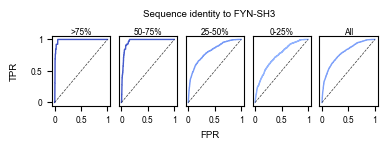

In [20]:
import matplotlib.pyplot as plt
from decimal import Decimal
from sklearn import metrics
from sklearn.model_selection import KFold
from IPython.display import display
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn import metrics
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

plt.rcParams["font.family"] = "Arial"

titles = {'in_nature_all':'All',
         'in_nature_0_25':'0-25%',
         'in_nature_25_50':'25-50%',
         'in_nature_50_75':'50-75%',
         'in_nature_75':'>75%'}

cmap = plt.get_cmap('coolwarm_r')

classifier_performances = pd.DataFrame()
fig, ax = plt.subplots(nrows=1, ncols=5, figsize=(2.8*1.5,0.6*1.5), sharex=True, sharey=True)
fig.subplots_adjust(wspace=0.15)
coliterator=0
for threshold in reversed(['in_nature_all', 'in_nature_0_25','in_nature_25_50', 'in_nature_50_75', 'in_nature_75']):

    # predictors (x): ddG
    # target variable (y): exists in nature?
    x = isofold_exist_clasf[['mean_dG']]
    y = isofold_exist_clasf[[threshold]]

    x, y = shuffle(x, y, random_state=3)
    
    # ROC curve
    fpr, tpr, thresholds = metrics.roc_curve(np.array(y).ravel(), np.array(-1*x).ravel())
    roc_auc = metrics.auc(fpr, tpr)
    ax[coliterator].plot(fpr, tpr, lw=1, alpha=1, color=cmap(roc_auc),
            label=r'(AUC=%0.2f)' % (roc_auc))
    
    classifier_performances.at[threshold,'AUC']=roc_auc
    
    ax[coliterator].plot([0, 1], [0, 1], linestyle='--', lw=0.5, color='k',
             label='', alpha=0.8)
        

    ax[coliterator].set_title(titles[threshold],fontsize=6, pad=0)
    ax[coliterator].set_xticks(np.arange(0,1.2,0.5), [Decimal(i).normalize() for i in np.arange(0,1.2,0.5)],fontsize=6)
    ax[coliterator].set_yticks(np.arange(0,1.2,0.5), [Decimal(i).normalize() for i in np.arange(0,1.2,0.5)],fontsize=6)
    if coliterator > 0:
        ax[coliterator].tick_params(axis='y',length=0)
    coliterator+=1
fig.text(0.5, -0.25, 'FPR', ha='center', fontsize=7)
fig.text(0.025, 0.5, 'TPR', va='center', rotation='vertical', fontsize=7)
fig.text(0.5, 1.1, 'Sequence identity to FYN-SH3', ha='center', fontsize=7)
plt.rcParams['svg.fonttype'] = 'none'
#fig.savefig('FYN_2ndordersprsregmodel_EBG_classifier_ROC-AUCs_curves_SeqIds.svg', dpi=300, transparent=True, bbox_inches='tight')

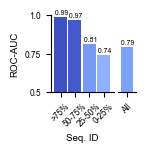

In [21]:
fig, ax = plt.subplot_mosaic([['left','right']],
                            width_ratios = [3.5,1],
                            figsize = (1.1,1))
axis=classifier_performances.iloc[:-1].plot.bar(y='AUC', color=cmap(list(classifier_performances['AUC'])), ax=ax['left'], legend=False, width=0.9, ylim=(0,1.05))
ax['left'].set_xticklabels(reversed(['0-25%', '25-50%', '50-75%', '>75%']), fontsize=6, rotation=45)
ax['left'].set_yticks(np.arange(0,1.2,0.25),[str(round(i,2)) for i in np.arange(0,1.2,0.25)], fontsize=6)
ax['left'].set_ylim(0.5,1)
ax['left'].set_xlabel('Seq. ID', fontsize=7)
ax['left'].set_ylabel('ROC-AUC',fontsize=7)
ax['left'].spines[['top','right']].set_visible(False)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=0)

axis=classifier_performances.iloc[-1:].plot.bar(y='AUC', color=cmap(list(classifier_performances.iloc[-1:]['AUC'])), ax=ax['right'], legend=False, width=0.9, ylim=(0,1.05))
ax['right'].spines[['top','right','left']].set_visible(False)
ax['right'].set_yticks([])
ax['right'].set_ylim(0.5,1)
ax['right'].set_xticklabels(reversed(['All']), fontsize=6, rotation=45)

for bar in axis.patches:
    height = bar.get_height()
    axis.text(bar.get_x() + bar.get_width() / 2.0, height+0.01, f' {height:.2f}', fontsize=5,
            ha='center', va='bottom', rotation=0)

plt.subplots_adjust(wspace=0.1)
plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('FYN_2ndordersprsregmodel_EBG_classifier_ROC-AUCs_SeqIds_2.svg', dpi=300, transparent=True, bbox_inches='tight')

## Panel b

In [22]:
import pandas as pd

permi_variants = pd.read_csv(path+'Fig6/FYN_suppressor_fitness_replicates.txt', sep='\t')


In [23]:
from seaborn import kdeplot
import numpy as np

def normalize(values, bounds):
    return [bounds['desired']['lower'] + (x - bounds['actual']['lower']) * (bounds['desired']['upper'] - bounds['desired']['lower']) / (bounds['actual']['upper'] - bounds['actual']['lower']) for x in values]

permi_variants_scaled = permi_variants.copy()

arbitraryWT='FLFFVIV'

fig, ax = plt.subplots()

my_kde = kdeplot(data=permi_variants.loc[permi_variants['fitness']<-0.5], x='fitness', ax=ax)

lines = my_kde.get_lines()
plt.close()
for line in lines:
    x, y = line.get_data()
    mode=(x[np.argmax(y)])
    ax.axvline(x[np.argmax(y)], ls='--')

permi_variants_scaled['fitness']=normalize(list(permi_variants_scaled['fitness']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness1_uncorr']=normalize(list(permi_variants_scaled['fitness1_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness1_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness2_uncorr']=normalize(list(permi_variants_scaled['fitness2_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness2_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})
permi_variants_scaled['fitness3_uncorr']=normalize(list(permi_variants_scaled['fitness3_uncorr']),{'actual': {'lower': mode, 'upper': permi_variants_scaled.loc[permi_variants_scaled['Nham_aa']==0]['fitness3_uncorr'].iloc[0]}, 'desired': {'lower': -1, 'upper': 0}})


fig, ax = plt.subplots()

my_kde = kdeplot(data=permi_variants_scaled, x='fitness', ax=ax)

lines = my_kde.get_lines()

for line in lines:
    x, y = line.get_data()

plt.close()

In [24]:
WTs_bearing_natural_DTS_core_queries=pd.read_csv(path+'Fig6/Structural_homologs_carrying_detrimental_cores_in_FYN.txt',sep='\t')

for index, row in permi_variants_scaled.iterrows():
    if row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['DSSP_boundaries']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_1']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_2']) or row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['Pro_mutant_3']):
        permi_variants_scaled.at[index,'other_natural_SH3s']=True
        if row.aa_seq in list(WTs_bearing_natural_DTS_core_queries['DSSP_boundaries']):
            permi_variants_scaled.at[index,'Pro_mutant']=False
        else:
            permi_variants_scaled.at[index,'Pro_mutant']=True

other_natural_SH3s = permi_variants_scaled.loc[permi_variants_scaled['other_natural_SH3s']==True].copy()

In [25]:
import math

for index, row in WTs_bearing_natural_DTS_core_queries.iterrows():
    try:
        WTs_bearing_natural_DTS_core_queries.at[index,'query_seq_fitness']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.DSSP_boundaries].iloc[0]['fitness']
        WTs_bearing_natural_DTS_core_queries.at[index,'query_seq_gr']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.DSSP_boundaries].iloc[0]['growthrate']
    except IndexError:
        continue
    try:
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_1_fitness']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_1].iloc[0]['fitness']
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_1_gr']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_1].iloc[0]['growthrate']
    except IndexError:
        continue
    try:
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_2_fitness']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_2].iloc[0]['fitness']
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_2_gr']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_2].iloc[0]['growthrate']
    except IndexError:
        continue
    try:
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_3_fitness']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_3].iloc[0]['fitness']
        WTs_bearing_natural_DTS_core_queries.at[index,'Pro_mutant_3_gr']=other_natural_SH3s.loc[other_natural_SH3s['aa_seq']==row.Pro_mutant_3].iloc[0]['growthrate']
    except IndexError:
        continue

for index, row in WTs_bearing_natural_DTS_core_queries.iterrows():
    grs = []
    fitnesses = []
    for i in range(1,4,1):
        if math.isnan(row['Pro_mutant_'+str(i)+'_gr']) == False:
            grs.append(row['Pro_mutant_'+str(i)+'_gr'])
            fitnesses.append(row['Pro_mutant_'+str(i)+'_fitness'])
    if len(grs) > 0:
        WTs_bearing_natural_DTS_core_queries.at[index,'mean_Pro_mutant_gr']=sum(grs)/len(grs)
        WTs_bearing_natural_DTS_core_queries.at[index,'mean_Pro_mutant_fitness']=sum(fitnesses)/len(fitnesses)

In [26]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid

def shiftedColorMap(cmap, start=0, midpoint=0.5, stop=1.0, name='shiftedcmap'):
    '''
    Function to offset the "center" of a colormap. Useful for
    data with a negative min and positive max and you want the
    middle of the colormap's dynamic range to be at zero.

    Input
    -----
      cmap : The matplotlib colormap to be altered
      start : Offset from lowest point in the colormap's range.
          Defaults to 0.0 (no lower offset). Should be between
          0.0 and `midpoint`.
      midpoint : The new center of the colormap. Defaults to 
          0.5 (no shift). Should be between 0.0 and 1.0. In
          general, this should be  1 - vmax / (vmax + abs(vmin))
          For example if your data range from -15.0 to +5.0 and
          you want the center of the colormap at 0.0, `midpoint`
          should be set to  1 - 5/(5 + 15)) or 0.75
      stop : Offset from highest point in the colormap's range.
          Defaults to 1.0 (no upper offset). Should be between
          `midpoint` and 1.0.
    '''
    cdict = {
        'red': [],
        'green': [],
        'blue': [],
        'alpha': []
    }

    # regular index to compute the colors
    reg_index = np.linspace(start, stop, 257)

    # shifted index to match the data
    shift_index = np.hstack([
        np.linspace(0.0, midpoint, 128, endpoint=False), 
        np.linspace(midpoint, 1.0, 129, endpoint=True)
    ])

    for ri, si in zip(reg_index, shift_index):
        r, g, b, a = cmap(ri)

        cdict['red'].append((si, r, r))
        cdict['green'].append((si, g, g))
        cdict['blue'].append((si, b, b))
        cdict['alpha'].append((si, a, a))

    newcmap = matplotlib.colors.LinearSegmentedColormap(name, cdict)
    plt.register_cmap(cmap=newcmap)

    return newcmap

iterator_cmap = 10

/var/folders/32/dtq6y36s6mjg1zcf2_9dskdm0000gn/T/ipykernel_8582/1720086963.py:53: MatplotlibDeprecationWarning: The register_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps.register(name)`` instead.
  plt.register_cmap(cmap=newcmap)


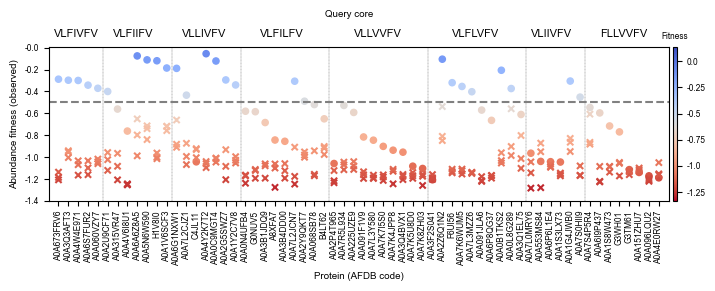

In [27]:
orig_cmap = plt.cm.coolwarm_r
norm = plt.Normalize(vmin=np.min(permi_variants_scaled['fitness']), vmax=np.max(permi_variants_scaled['fitness']))
iterator_cmap+=1
midpoint=(-0.5 - np.min(permi_variants_scaled['fitness']))/ (np.max(permi_variants_scaled['fitness']) - np.min(permi_variants_scaled['fitness']))
shifted_cmap = shiftedColorMap(orig_cmap, midpoint=midpoint, name='shifted'+str(iterator_cmap))

fig, ax = plt.subplots(figsize=(8,2))

len_previous=WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].value_counts().loc[list(WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].unique())[0]]
position=0
for natcore in list(WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].unique()):
    len_current=WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].value_counts().loc[natcore]
    plt.text(position-0.5+(len_current-min(WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].value_counts()))/2, 0.1, natcore, fontsize=8)
    len_previous=WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].value_counts().loc[natcore]
    position=len_previous+position
    if list(WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].unique()).index(natcore) != len(list(WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['MutCore'].unique()))-1:
        plt.axvline(position-0.5, ls='--', color='k', lw=0.2)
    
fig.text(0.5, 1.03, 'Query core', ha='center', fontsize=7)
    
WTs_bearing_natural_DTS_core_queries=WTs_bearing_natural_DTS_core_queries.sort_values(['MutCore','query_seq_fitness'], ascending=[True,False])
WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()].plot.scatter(x='AF_code', y='query_seq_fitness', ax=ax, c = shifted_cmap(norm(WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['query_seq_fitness'])))
for pro_mutant in range(1,4,1):
    WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()].plot.scatter(x='AF_code', y='Pro_mutant_'+str(pro_mutant)+'_fitness', marker='x', ax=ax, c = shifted_cmap(norm(WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()]['Pro_mutant_'+str(pro_mutant)+'_fitness'])))
plt.axhline(-0.5, color='gray', ls='--')
ax.set_xticks(ax.get_xticks(),ax.get_xticklabels(),rotation=90, fontsize=6)
ax.set_yticks(np.arange(-1.4,0.1,0.2),[str(round(i,1)) for i in np.arange(-1.4,0.1,0.2)], fontsize=6)
ax.set_xlabel('Protein (AFDB code)', fontsize=7)
ax.set_ylabel('Abundance fitness (observed)', fontsize=7)
plt.xlim(-1,len(WTs_bearing_natural_DTS_core_queries.loc[WTs_bearing_natural_DTS_core_queries['fitness'].notnull()].loc[WTs_bearing_natural_DTS_core_queries['mean_Pro_mutant_fitness'].notnull()].index))

cax=fig.add_axes([0.905,0.11,0.005,0.77])
cb=fig.figure.colorbar(plt.cm.ScalarMappable(cmap=orig_cmap, norm=norm), cax=cax, orientation='vertical')
cax.set_yticks(np.arange(-1.25,0.25,0.25), np.arange(-1.25,0.25,0.25), fontsize=6)
cb.outline.set_visible(True)
cb.ax.set_title('Fitness', fontsize=6)

plt.rcParams['svg.fonttype'] = 'none'
#plt.savefig('Proteins_with_detrimental_cores_in_FYN_fitness.svg', dpi=300, transparent=False, bbox_inches='tight')